In [5]:
import pandas as pd
import numpy as np

In [6]:
def openFile(file) -> pd.DataFrame:
    return pd.read_table(file, header = [3], encoding = 'ANSI', sep = ',')


In [7]:
filedata = openFile('Extrudat20230818_13.TRA')
filedata

,s,N,mm,mm.1
0,0.019932,0.016736,0.000012,90.0000
1,0.079932,0.050880,0.000012,90.0000
2,0.099932,0.033807,0.000012,90.0000
3,0.519932,-0.000336,0.000012,90.0000
4,0.659932,-0.017408,0.014358,90.0143
...,...,...,...,...
3445,107.840000,1.365420,53.602000,143.6020
3446,107.880000,1.365420,53.621900,143.6220
3447,107.920000,1.365420,53.640500,143.6400
3448,108.600000,1.348350,53.650000,143.6500


In [8]:
def getStrain(data) -> pd.Series:
    return np.log(filedata['mm.1'] / filedata['mm.1'][0])

def getStress(data) -> pd.Series:
    return filedata['N']

In [9]:
getStrain(filedata)

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000159
          ...   
3445    0.467236
3446    0.467375
3447    0.467500
3448    0.467570
3449    0.467570
Name: mm.1, Length: 3450, dtype: float64

In [10]:
getStress(filedata)

0       0.016736
1       0.050880
2       0.033807
3      -0.000336
4      -0.017408
          ...   
3445    1.365420
3446    1.365420
3447    1.365420
3448    1.348350
3449    1.416640
Name: N, Length: 3450, dtype: float64

In [11]:
def getStressStrain(data) -> pd.DataFrame:
    strain = getStrain(data)
    stress = getStress(data)
    return pd.DataFrame({'strain': strain, 'stress': stress})

In [12]:
stress = getStressStrain(filedata)

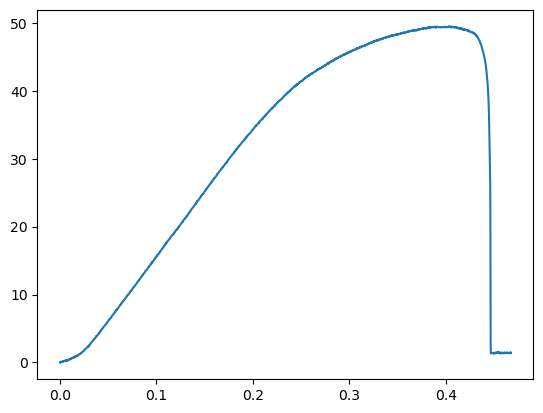

In [75]:
def plotStressStrain(data):
    import matplotlib.pyplot as plt
    plt.plot(data['strain'], data['stress'])
plotStressStrain(stress)

In [57]:
from sklearn.linear_model import LinearRegression
import scipy
model = LinearRegression()

In [107]:
def getBestFit(stressData, window = 500):
    step = 10
    
    left = 0
    right = window
    coeff = pd.DataFrame()
    
    lengthStressData = len(stressData)
    
    while True:
        if right > len(stressData): 
            break

        data = stressData[left:right]

        model.fit(data[['strain']], data[['stress']])
        slope = model.coef_[0]
        intercept = model.intercept_
        y_exp = slope * data['strain'] + intercept
        error = (data['stress'] - y_exp)**2

        coeff = pd.concat([coeff, pd.DataFrame({'strain': data.iloc[100].strain, 'slope': slope, 'intercept': intercept, 'error': error.sum()})],axis=0)

        left += step
        right += step
        
        bestFit = coeff[coeff['error'] == coeff['error'].min()].iloc[0]
    return bestFit

In [108]:
getBestFit(stress)

strain         0.066743
slope        190.615514
intercept     -3.466967
error          0.526160
Name: 0, dtype: float64

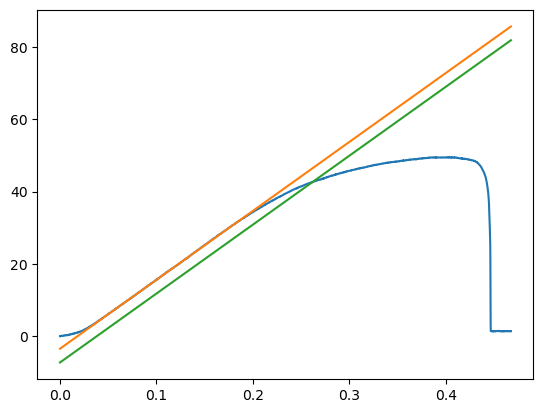

In [104]:
step = 10
left = 0
right = 500
coeff = pd.DataFrame()
while True:
    if right > len(stress): 
        break
    
    data = stress[left:right]
    
    model.fit(data[['strain']], data[['stress']])
    slope = model.coef_[0]
    intercept = model.intercept_
    y_exp = slope * data['strain'] + intercept
    error = (data['stress'] - y_exp)**2

    coeff = pd.concat([coeff, pd.DataFrame({'strain': data.iloc[100].strain, 'slope': slope, 'intercept': intercept, 'error': error.sum()})],axis=0)
    
    left += step
    right += step
    
import matplotlib.pyplot as plt
best = coeff[coeff['error'] == coeff['error'].min()].iloc[0]

plt.plot(stress['strain'], stress['stress'])
line = best.slope * stress['strain']+ best.intercept
other = best.slope *(stress['strain']-0.02) + best.intercept
plt.plot(stress['strain'], line)
plt.plot(stress['strain'], other)
